# Ex09 - Técnicas de segmentação

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import sys,os
ia898path = os.path.abspath('../../')
if ia898path not in sys.path:
    sys.path.append(ia898path)
import ia898.src as ia

In [2]:
# glue matrices side by side
def glue(m_list):
    glued_mtrx = m_list[0]
    amount = len(m_list)
    for i in range(1,amount):
        glued_mtrx = np.concatenate((glued_mtrx, m_list[i]), axis=1)
    return glued_mtrx

### Parte 1 - Segmentando múltiplos objetos por limiarização

A limiarização também pode ser feita em imagens com mais de um objeto e usando limiares múltiplos. Tente segmentar separadamente a cartela de comprimidos em uma imagem e os comprimidos em outra. Utilize o hstograma da imagem para escolher os limiares.

### Cartela de Remédio

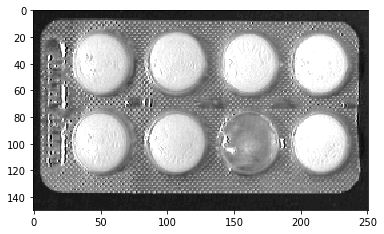

In [3]:
im2 = mpimg.imread('../data/astablet.tif')
plt.imshow(im2, cmap='gray')

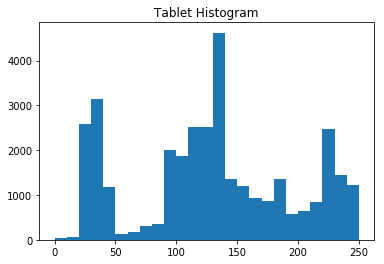

In [4]:
tablet_mat = np.asarray(Image.open("../data/astablet.tif"), dtype="uint8")

plt.hist(tablet_mat.flatten(), bins=np.arange(0,255,10), density=False)
plt.title("Tablet Histogram")
plt.show()

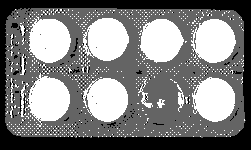

In [5]:
T = np.zeros(256)
T[90:180] = 100
T[180:]  = 255
seg = T[tablet_mat]
Image.fromarray(seg.astype("uint8"))

In [6]:
T1 = np.zeros(256)
T2 = np.zeros(256)
T3 = np.zeros(256)
T1[90:180] = 255
T2[180:]  = 255

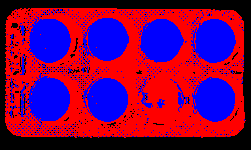

In [7]:
segmentation = Image.new("RGB", (tablet_mat.shape[1], tablet_mat.shape[0]))
segmentation.paste(Image.open("../data/astablet.tif"))
rgb_seg = np.asarray(segmentation)
rgb_seg.setflags(write=1)
rgb_seg = rgb_seg.transpose(2,0,1)
rgb_seg[0] = T1[rgb_seg[0]]
rgb_seg[1] = T3[rgb_seg[1]]
rgb_seg[2] = T2[rgb_seg[2]]
Image.fromarray(rgb_seg.transpose(1,2,0))

### Gordura de um bife

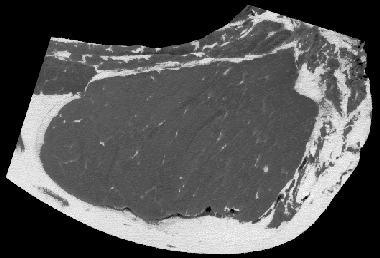

In [8]:
beef = Image.open("../data/beef.tif")
beef_mat = np.asarray(beef, dtype="uint8")
beef

Para obtermos um melhor resultado, "eliminamos" as pequenas gorduras entre a carne fazendo a operaçao de erosão na imagem. 

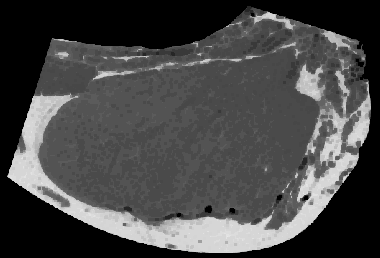

In [9]:
from scipy.ndimage.morphology import grey_closing, grey_dilation, grey_erosion, grey_opening
beef_mat = grey_erosion(beef_mat, size=(3,3), mode="nearest")
Image.fromarray(beef_mat)

Agora podemos fechar os "buracos" da imagem aplicando a operação de fechamento da imagem.

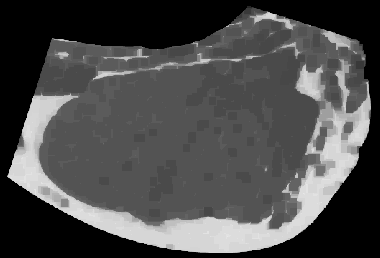

In [10]:
beef_mat = grey_closing(beef_mat, size=(7,7))
Image.fromarray(beef_mat)

Observando o histograma podemos determinar os valores de threashold para segregar a carne da gordura. Poderíamos automatizar o processo de encontrar os limiares corretos escrevendo uma função que determine os minimos locais do histograma "suavizado".

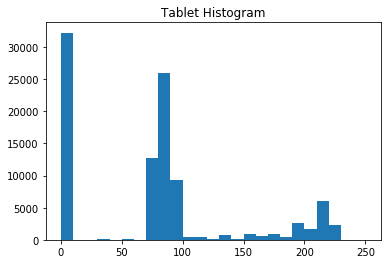

In [11]:
plt.hist(beef_mat.flatten(), bins=np.arange(0,255,10), density=False)
plt.title("Tablet Histogram")
plt.show()

Utilizando os limiares 40  e 130 obtemos a seguinte segmentação em nível de cinza.

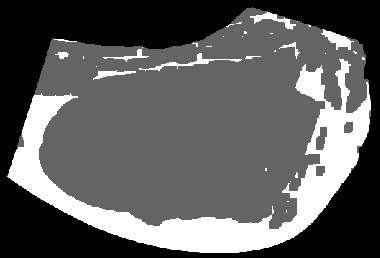

In [12]:
T = np.zeros(256)
T[40:130] = 100
T[130:]  = 255
seg = T[beef_mat]
Image.fromarray(seg.astype("uint8"))

In [13]:
T1 = np.zeros(256)
T2 = np.zeros(256)
T3 = np.zeros(256)
T1[40:130] = 255
T2[130:]  = 255

In [14]:
segmentation = Image.new("RGB", (2*beef_mat.shape[1], beef_mat.shape[0]))
segmentation.paste(Image.fromarray(beef_mat))
rgb_seg = np.asarray(segmentation)
rgb_seg.setflags(write=1)
rgb_seg = rgb_seg.transpose(2,0,1)
rgb_seg[0] = T1[rgb_seg[0]]
rgb_seg[1] = T3[rgb_seg[1]]
rgb_seg[2] = T2[rgb_seg[2]]

Abaixo podemos comparar visualmente a segmentação com a imagem original.

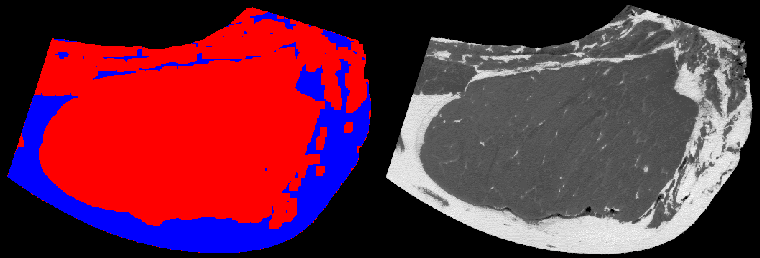

In [15]:
rgb_seg = Image.fromarray(rgb_seg.transpose(1,2,0))
rgb_seg.paste(beef, (beef.size[0], 0))
rgb_seg

### Parte 2 - Demonstração da limiarização por Otsu

Tente melhorar a demonstração da limiarização por Otsu ([Demo](../master/otsudemo.ipynb)).

In [16]:
def otsu(f):
     n = np.product(np.shape(f))
     h = 1.*np.bincount(f.ravel()) / n  
     if len(h) == 1: return 1,1
     x = np.arange(np.product(np.shape(h)))
     w0 = np.cumsum(h)
     w1 = 1 - w0
     eps = 1e-10
     m0 = np.cumsum(x * h) / (w0 + eps)
     mt = m0[-1]
     m1 = (mt - m0[0:-1]*w0[0:-1]) / w1[0:-1]
     sB2 = w0[0:-1] * w1[0:-1] * ((m0[0:-1] - m1)**2)
     t = np.argmax(sB2)
     v = sB2[t]
     st2 = sum((x-mt)**2 * h)
     eta = v / st2
     return t, eta

### Segmentação da gordura de um bife pelo método de limiarização de Otsu

Primeiro, realiazamos os mesmo passos feitos para melhorar a segmentação quando realizamos a limiarização simples.

In [17]:
from scipy.ndimage.morphology import grey_closing, grey_dilation, grey_erosion, grey_opening
beef_mat = np.asarray(beef, dtype="uint8")
beef_mat = grey_erosion(beef_mat, size=(3,3), mode="nearest")
beef_mat = grey_closing(beef_mat, size=(7,7))

Agora, utilizamos o algoritmo de Otsu para encontrar o melhor limiar que segmenta os objetos da imagem. O conceito proposto é de iterar por todos os valores possíveis para o threshold na imagem, ou seja, o intervalo dinâmico da imagem, buscando aquele que minimiza a soma da variância intraclasses da imagem. Esse valor irá corresponder ao melhor threshold para o caso.

In [ ]:
t, _ = otsu(beef_mat)

#### Segmentação da gordura

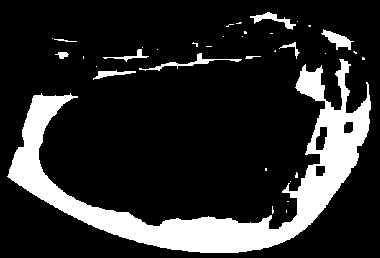

In [29]:
fat_seg = beef_mat.copy()

fat_seg[fat_seg > t] = 255
fat_seg[fat_seg < t] = 0

Image.fromarray(fat_seg)

#### Segmentação da carne

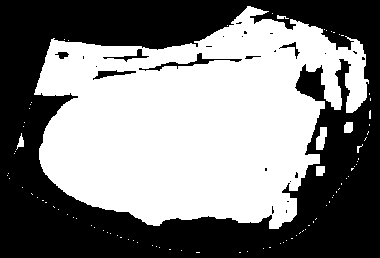

In [26]:
meat_seg = beef_mat.copy()
meat_seg[meat_seg > t] = 0
meat_seg[meat_seg > 0] = 255

Image.fromarray(meat_seg)

In [27]:
segmentation = Image.new("RGB", (2*beef_mat.shape[1], beef_mat.shape[0]))
segmentation.paste(Image.fromarray(beef_mat))
rgb_seg = np.asarray(segmentation)
rgb_seg.setflags(write=1)
rgb_seg = rgb_seg.transpose(2,0,1)
rgb_seg[0] = glue([meat_seg, np.zeros(meat_seg.shape)])
rgb_seg[1] *=0
rgb_seg[2] = glue([fat_seg, np.zeros(meat_seg.shape)])

Como o objetivo do algoritmo proposto por Otsu é determinar o valor ideal de threashold que separe os elementos da imagem ele irá funcionar especialmente bem para casos de imagens com histogramas bimodais, podendo ser divididas adequadamente com um único valor. Assim, o método irá apresentar resultados mais fracos à medida que a imagem em questão se afasta desse padrão. Abaixo podemos observar o resultado da segmentação.

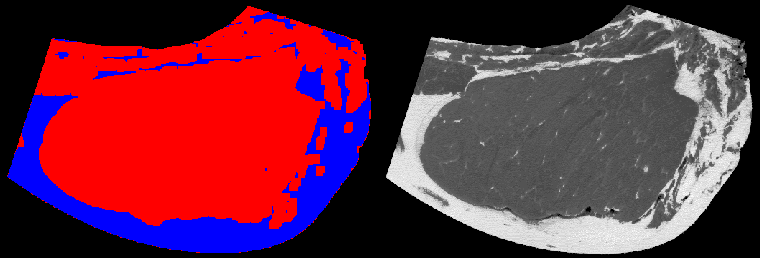

In [28]:
rgb_seg = Image.fromarray(rgb_seg.transpose(1,2,0))
rgb_seg.paste(beef, (beef.size[0], 0))
rgb_seg

### Parte 3 - Segmentação por watershed

Tentem reproduzir a demonstração de segmentação por watershed da antiga toolbox ([pdf](../data/ia870_iadbeef.pdf)). Vocês podem usar as funções de watershed implementadas na biblioteca *scipy.ndimage.measurements* ou *skimage.morphology*. Você pode também se inspirar no Seminário do Eduardo ([link](./Seminarios/Watershed.ipynb)).
Quem quiser conhecer todos os algoritmos da Transformada de Watershed, eles estão descritos na Toolbox de Watershed desenvolvida por um de nossos alunos ([Toolbox Watershed](http://adessowiki.fee.unicamp.br/adesso/wiki/watershed/view/))

In [250]:
from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import rank
from scipy import ndimage
import warnings

### Segmentação da gordura de um bife pelo método de limiarização de Otsu

Agora, eu tentarei reproduzir a demonstração de segmentação por watershed da gordura de uma carne ilustrada aqui ([pdf](../data/ia870_iadbeef.pdf)).

Primeiro, iremos encontrar os marcadores tanto para a carne quanto para a gordura. Para a carne fazemos uma severa operação de erosão na imagem.

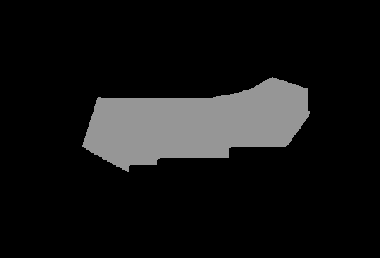

In [454]:
from scipy.ndimage.morphology import grey_closing, grey_dilation, grey_erosion, grey_opening
beef_mat = np.asarray(beef, dtype="uint8")
f = grey_erosion(beef_mat, size=(100,100), mode="nearest")
f[f>0] = 150
Image.fromarray(f)

Para o marcador da gordura queremos que ele esteja na borda do bife, assim, podemos computar o gradiente da imagem limiarizada por um threashold baixo.

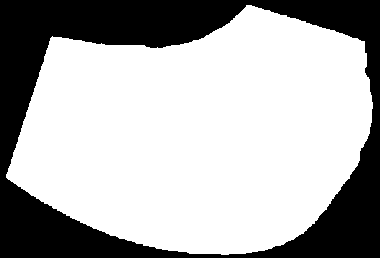

In [455]:
c = beef_mat.copy()
c[c>10] = 255
c = grey_closing(c,size=(5,5))
Image.fromarray(c)

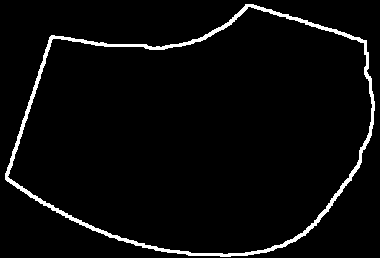

In [456]:
e = rank.gradient(image=c, selem=np.ones((4,4)))
Image.fromarray(e)

Agora, fazemos a união dos marcadores para podermos aplicar o algoritmo de watershed

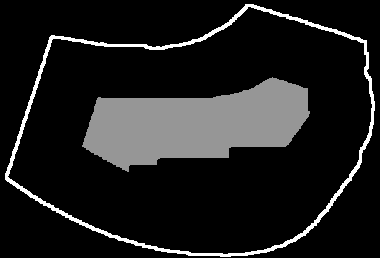

In [457]:
markers = f + e
Image.fromarray(markers)

Computamos também o gradiente da imagem do bife para usá-lo como imagem fonte no algoritmo de watershed.

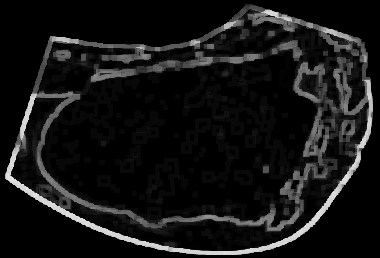

In [461]:
beef_mat = np.asarray(beef, dtype="uint8")
beef_mat = grey_erosion(beef_mat, size=(3,3), mode="nearest")
beef_mat = grey_closing(beef_mat, size=(7,7))
h = rank.gradient(beef_mat.copy(), selem=np.ones((5,5)))
Image.fromarray(h)

In [462]:
warnings.filterwarnings('ignore')
labels = watershed(beef_mat, markers, mask=beef_mat)
warnings.filterwarnings('default')

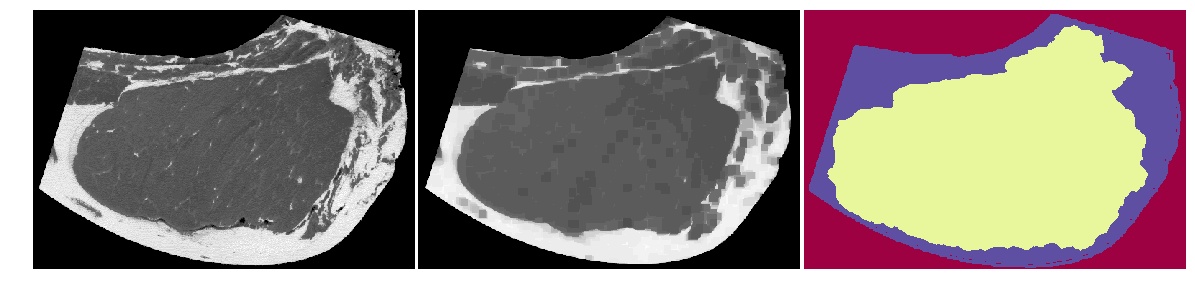

In [463]:
plt.figure(figsize=(16, 16))
plt.subplot(131)
plt.imshow(np.asarray(beef), cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(beef_mat, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap="Spectral", interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,right=1)
plt.show()

Acima, temos a imagem original, seguida da imagem suavisada (imagem que de fato foi usada para computar os dados) e por último o resultado da segmentação. Se compararmos com o resultado obtido tanto pelo algoritmo de Otsu quanto pela limiarização simples percebemos que o resultado está bem abaixo do esperado. Porém, a técnica pode ser muito melhor explorada do que foi feito aqui, obtendo resultados muito melhores que os outro algoritmos em outras ocasiôes.